# Propensity Score Matching and Balance Measures using R MatchIt and Cobalt
This is based on the work in the notebook `dr_learner_with_synthetic_data.ipynb`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install rpy2

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import BaseXRegressor, BaseDRRegressor
from causalml.inference.iv import BaseDRIVRegressor
from causalml.dataset import synthetic_data
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Failed to import duecredit due to No module named 'duecredit'


In [4]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

## Synthetic Data Generation

In [5]:
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

In [6]:
y # outcome variable
# X # independent variables
# treatment # w, treatment flag
# tau # individual treatment effect
# b # expected outcome
# e # treatment propensity

array([2.76500463, 2.59048229, 2.87995079, ..., 2.20567733, 2.58750291,
       1.61012383])

In [7]:
e.shape
e[:10]

array([0.9       , 0.9       , 0.50604813, 0.1       , 0.45716273,
       0.1       , 0.9       , 0.2212624 , 0.38603079, 0.1       ])

## Comparing DR Learner with X Learner

We use a flexible ML estimator to estimate the outcome model but a simple linear regression model to estimate the ITE, since the ITE estimate is often noisy and prone to overfit with a flexible estimator.

In [8]:
learner_x = BaseXRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y)

In [9]:
learner_dr = BaseDRRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_dr = learner_dr.fit_predict(X=X, treatment=treatment, y=y)

DR Learner outforms X Learner in this dataset. Even with built-in mechanism to counteract the unbalancedness between the treatment and control samples, X Learner still suffers from the regime where the treatment probability is close to 1 in this case.

Text(0.5, 1.0, 'DR Learner')

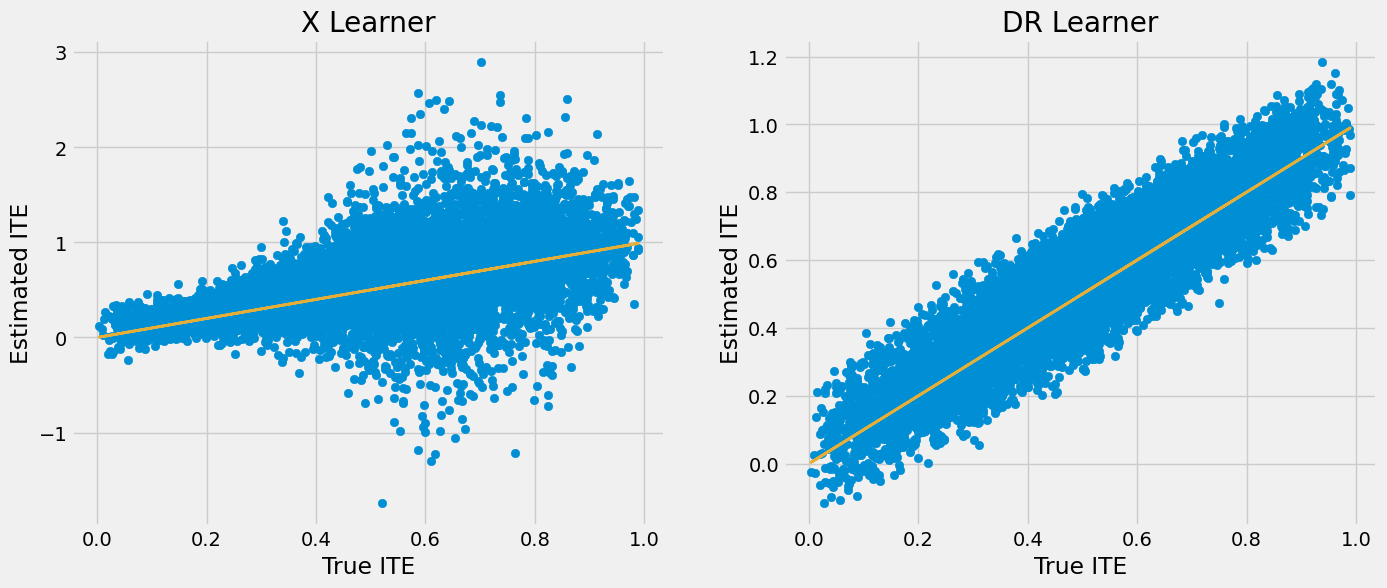

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].scatter(tau, cate_x)
ax[0].plot(tau, tau, color='C2', linewidth=2)
ax[0].set_xlabel('True ITE')
ax[0].set_ylabel('Estimated ITE')
ax[0].set_title('X Learner')
ax[1].scatter(tau, cate_dr)
ax[1].plot(tau, tau, color='C2', linewidth=2)
ax[1].set_xlabel('True ITE')
ax[1].set_ylabel('Estimated ITE')
ax[1].set_title('DR Learner')

# Create Pandas DataFrame and convert to R/rpy2 DataFrame

In [11]:
tmp = pd.DataFrame(X)
tmp.iloc[:,0]
tmp = tmp.add_prefix("X")
#tmp.columns.values.astype(str)
tmp["W"] = treatment
tmp

,X0,X1,X2,X3,X4,X5,X6,X7,W
0,0.586589,0.991207,0.744511,0.519736,0.878322,0.359879,0.638211,0.075087,1
1,0.891342,0.447589,0.973424,0.734327,0.322891,0.139873,0.011507,0.664846,1
2,0.381366,0.442867,0.100353,0.623690,0.893764,0.080593,0.039271,0.665376,1
3,0.624066,0.010873,0.185100,0.617392,0.673671,0.601274,0.174346,0.887321,0
4,0.347349,0.435108,0.869509,0.730408,0.670554,0.023075,0.325763,0.137806,0
...,...,...,...,...,...,...,...,...,...
9995,0.044390,0.729274,0.568361,0.236872,0.997069,0.400408,0.871065,0.669543,0
9996,0.854613,0.923613,0.017330,0.453840,0.795802,0.920449,0.954527,0.357436,1
9997,0.643673,0.137633,0.027273,0.928086,0.405790,0.580106,0.141902,0.354425,1
9998,0.831406,0.415311,0.930635,0.659079,0.414942,0.724334,0.429050,0.697254,0


In [12]:
with (ro.default_converter + pandas2ri.converter).context():
  r_from_pd_df = ro.conversion.get_conversion().py2rpy(tmp)

r_from_pd_df

X0,X1,X2,...,X6,X7,W
0.586589,0.991207,0.744511,...,0.638211,0.075087,1
0.891342,0.447589,0.973424,,0.011507,0.664846,1
0.381366,0.442867,0.100353,,0.039271,0.665376,1
0.624066,0.010873,0.185100,,0.174346,0.887321,0
...,...,...,,...,...,...
0.854613,0.923613,0.017330,,0.954527,0.357436,1
0.643673,0.137633,0.027273,,0.141902,0.354425,1
0.831406,0.415311,0.930635,,0.429050,0.697254,0
0.949166,0.067041,0.319666,,0.549514,0.387863,1


# Matching

We will use R's MatchIt package to create a matched subset of treated and control subjects for subsequent analysis.  then we will illustrate that matching improves balance, by using the R Cobalt package to compare covariate distributions visually.

Note that PSM is redundant from a theoretical point of view, but some users report having had good results in practice, as stated in [this issue](https://github.com/uber/causalml/issues/430):

> Propensity score matching is not required for estimating ATEs with meta-learners so long as the covariates that you use block any back-door paths between the treatment and outcome.

> Then again, if the covariates don't block all back-door paths between the treatment and outcome, the matching step will not achieve its intended goal of balancing confounders between treatment and control observations.

> Consequently, using matching with meta-learners is redundant from a theoretical point of view. That said, my understanding is that some users have had good results in practice when combining matching with meta-learners.

We explore if using PSM improves results for this test case and illustrate that in agreement with the theoretical prediction, it does not.  Nevertheless, understanding balance properties can be helpful for diagnosing issues related to covariate distributions.

In [20]:
import rpy2.ipython

%reload_ext rpy2.ipython

# import rpy2's package module
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr, data
from rpy2.robjects import Formula

cobalt = rpackages.importr('cobalt')
matchit = rpackages.importr('MatchIt')

# First explore full sample distribution

In [22]:
# match on nuisance variables
#formula = Formula('W ~ X0 + X1')
formula = Formula('W ~ .')


# rpy2.rinterface.NULL
mout = matchit.matchit(formula = formula, data=r_from_pd_df,
                       method = rpy2.rinterface.NULL, distance="glm", link="probit")

# Display full sample balance plots 

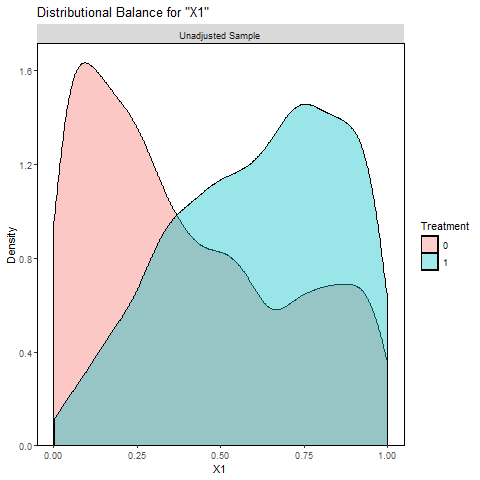

In [23]:
%%R -i mout
library("ggplot2", "cobalt", "MatchIt")
bal.plot(mout, var.name="X1")


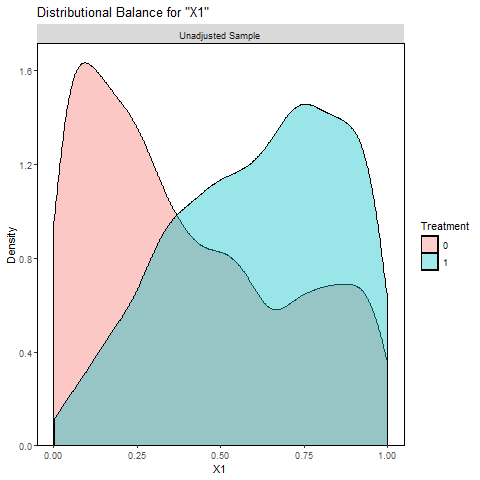

In [24]:
%%R -i mout
library("ggplot2", "cobalt", "MatchIt")
bal.plot(mout, var.name="X1")


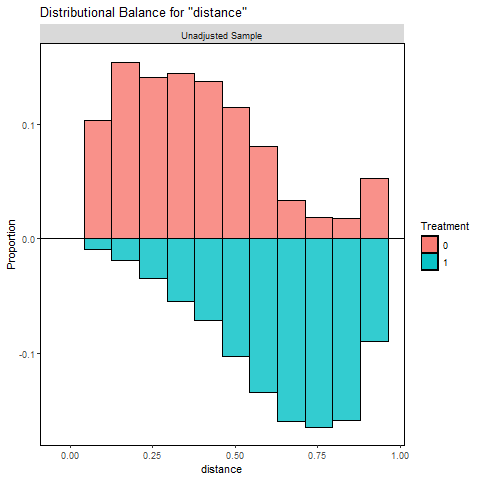

In [25]:
%%R
bal.plot(mout, var.name = "distance", 
    mirror = TRUE, type = "histogram")

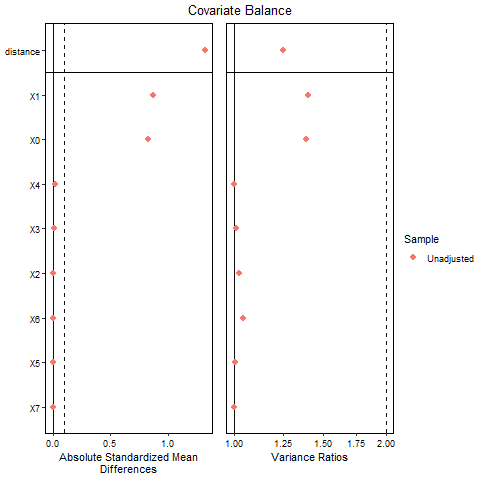

In [26]:
%%R
#Generating a Love plot to report balance:
love.plot(mout, stats = c("mean.diffs", "variance.ratios"),
          thresholds = c(m = .1, v = 2), abs = TRUE, 
          binary = "std",
          var.order = "unadjusted")

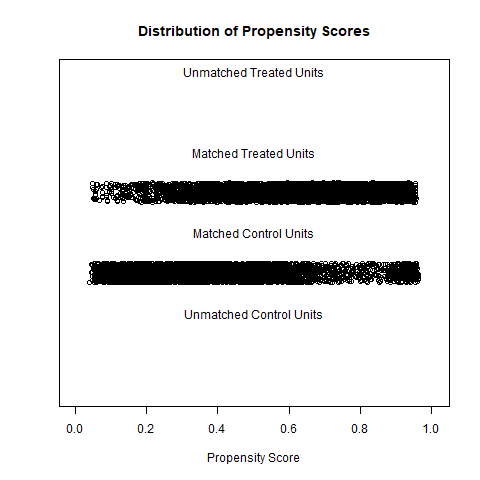

In [27]:
%%R

plot(mout, type = "jitter", interactive = FALSE)

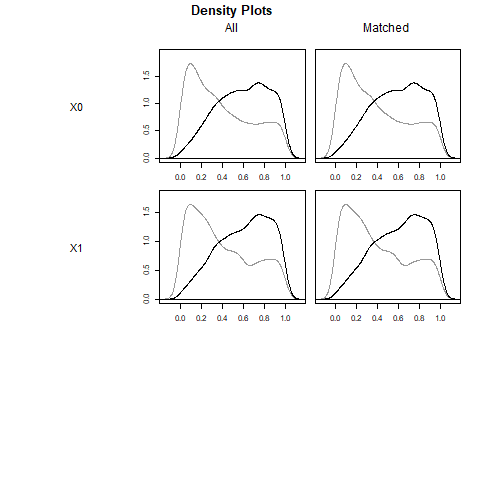

In [28]:
%%R

plot(mout, type = "density", interactive = FALSE,
     which.xs = ~X0+X1)

# Use MatchIt to improve balance

In [29]:
# poor results: nearest neighbor matching
# mout = matchit.matchit(formula = formula, data=r_from_pd_df, method = "nearest",
#                        distance="glm")

# better results via full matching (slow)
# mout = matchit.matchit(formula = formula, data=r_from_pd_df, method = "full", 
#                        distance="glm", link="probit")

# biased results via fast generalize full matching and glm (log-reg)
# https://kosukeimai.github.io/MatchIt/reference/method_quick.html
# mout = matchit.matchit(formula = formula, data=r_from_pd_df, method = "quick", 
#                        distance="glm")

# better results via fast generalized full matching and gbm (slow)
# https://kosukeimai.github.io/MatchIt/reference/method_quick.html
# mout = matchit.matchit(formula = formula, data=r_from_pd_df, method = "quick", 
#                        distance="gbm")

# better results via fast generalized full matching and gbm (slow)
# https://kosukeimai.github.io/MatchIt/reference/method_quick.html
# mout = matchit.matchit(formula = formula, data=r_from_pd_df, method = "quick", 
#                        distance="gbm", ratio=3)

# better results via fast generalized full matching and elasticnet
# https://kosukeimai.github.io/MatchIt/reference/method_quick.html
# formula = Formula('W ~ X0 + X1')
formula = Formula('W ~ X0 + X1 + X2 + X3 + X4 + X5 + X6 + X7')
mout = matchit.matchit(formula = formula, data=r_from_pd_df, method = "quick", 
                       distance="elasticnet", caliper=0.001)

#Checking balance before and after matching:
bt = cobalt.bal_tab(mout, un = True) #, thresholds = c(m = .1),)
print(bt)

Balance Measures
             Type Diff.Un Diff.Adj
distance Distance  1.3116   0.0000
X0        Contin.  0.8231   0.0267
X1        Contin.  0.8698  -0.0257
X2        Contin.  0.0080  -0.0369
X3        Contin. -0.0132  -0.0342
X4        Contin.  0.0230   0.0130
X5        Contin.  0.0006   0.0036
X6        Contin.  0.0014   0.0121
X7        Contin. -0.0003   0.0091

Sample sizes
                     Control Treated
All                  4802.      5198
Matched (ESS)        1341.56    2713
Matched (Unweighted) 2738.      2713
Unmatched            2064.      2485



# Illustrate matching improves covariate balance

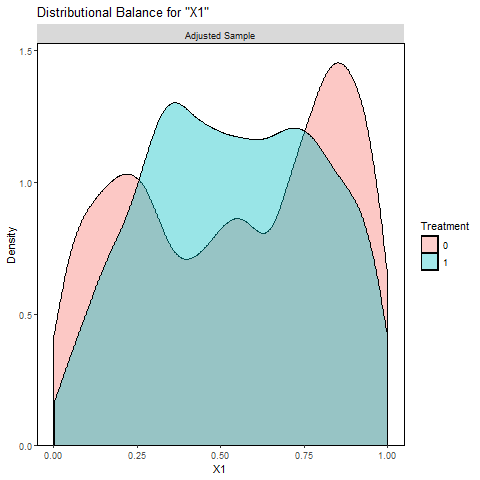

In [30]:
%%R -i mout
library("ggplot2", "cobalt", "MatchIt")
bal.plot(mout, var.name="X1")


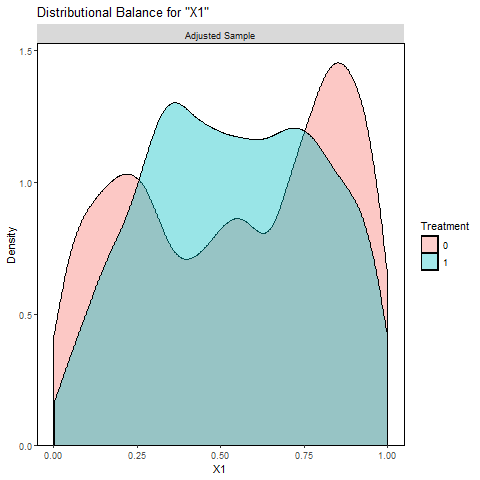

In [31]:
%%R -i mout
library("ggplot2", "cobalt", "MatchIt")
bal.plot(mout, var.name="X1")


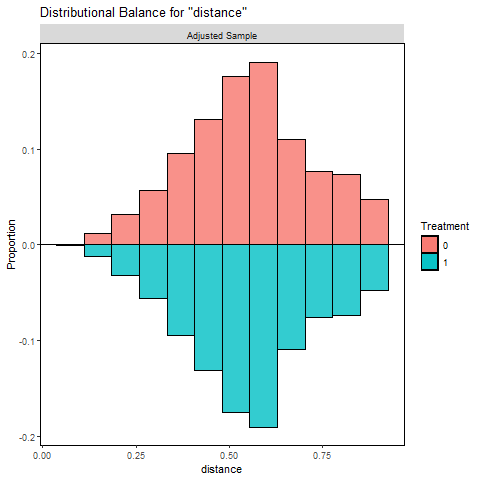

In [32]:
%%R
bal.plot(mout, var.name = "distance", 
    mirror = TRUE, type = "histogram")

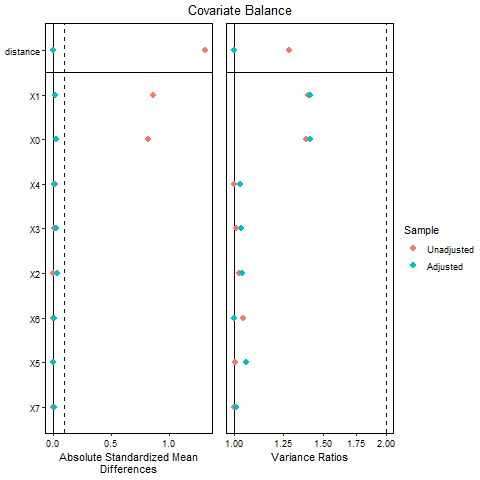

In [33]:
%%R
#Generating a Love plot to report balance:
love.plot(mout, stats = c("mean.diffs", "variance.ratios"),
          thresholds = c(m = .1, v = 2), abs = TRUE, 
          binary = "std",
          var.order = "unadjusted")

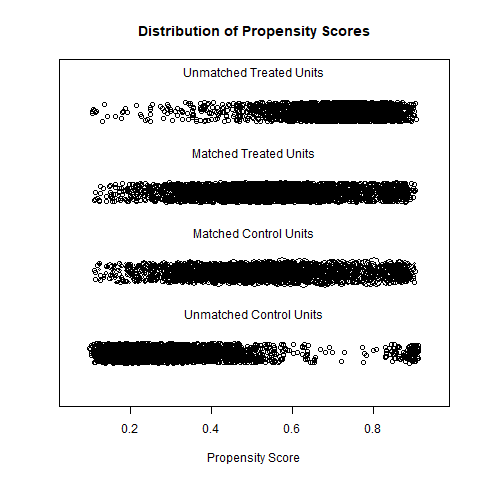

In [34]:
%%R

plot(mout, type = "jitter", interactive = FALSE)

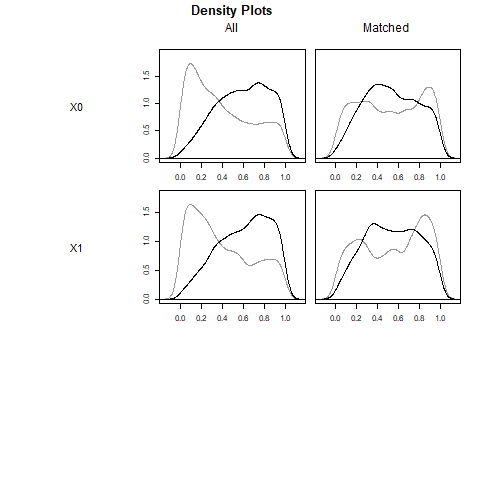

In [35]:
%%R

plot(mout, type = "density", interactive = FALSE,
     which.xs = ~X0+X1)

# Created DataFrames of matched subjects

https://kosukeimai.github.io/MatchIt/reference/match.data.html

Note:
- **match_data** gets 1 row per subject unit
- **get_matches** will create repeated rows when there are multiple matches

In [65]:
matched_rdf = matchit.match_data(mout)
#matched_rdf = matchit.get_matches(mout)
#matched_rdf

In [64]:
with (ro.default_converter + pandas2ri.converter).context():
  matched_df = ro.conversion.get_conversion().rpy2py(matched_rdf)

#matched_df

# Re-run learner using matched samples

In [60]:
learner_x = BaseXRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_x = learner_x.fit_predict(X=X[matched_df.index.astype(int)],
                               treatment=treatment[matched_df.index.astype(int)],
                               y=y[matched_df.index.astype(int)])

In [61]:
learner_dr = BaseDRRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_dr = learner_dr.fit_predict(X=X[matched_df.index.astype(int)],
                               treatment=treatment[matched_df.index.astype(int)],
                               y=y[matched_df.index.astype(int)])

In [62]:
cate_x.shape

(5451, 1)

Text(0.5, 1.0, 'DR Learner')

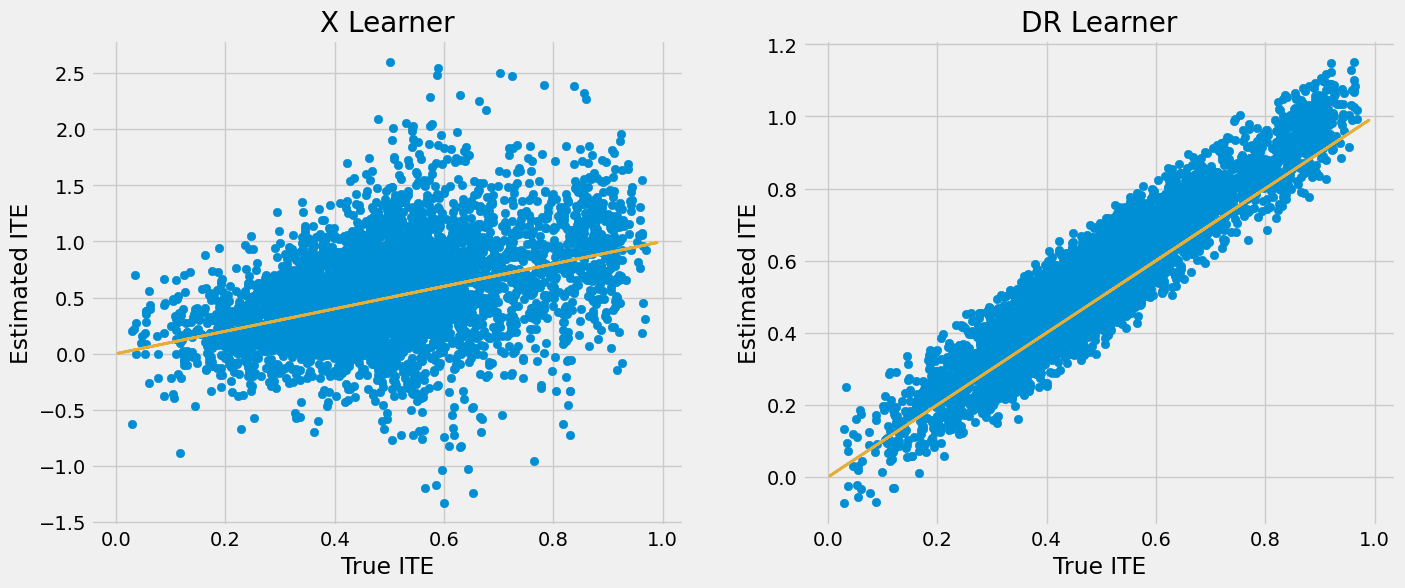

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].scatter(tau[matched_df.index.astype(int)], cate_x)
ax[0].plot(tau, tau, color='C2', linewidth=2)
ax[0].set_xlabel('True ITE')
ax[0].set_ylabel('Estimated ITE')
ax[0].set_title('X Learner')
ax[1].scatter(tau[matched_df.index.astype(int)], cate_dr)
ax[1].plot(tau, tau, color='C2', linewidth=2)
ax[1].set_xlabel('True ITE')
ax[1].set_ylabel('Estimated ITE')
ax[1].set_title('DR Learner')

# Summary

As we can see, the results using the full sample and with a propensity-score-matched subsample do not differ much.  Nevertheless, it can be helpful to understand if there are extreme covariate imbalances in the data and this is done well by the distributional graphs and heuristics provided in Cobalt.